In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
pd.set_option('display.max_columns', 500)

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

In [83]:
raw_df = pd.read_csv('rosbank_train.csv')
raw_df['channel_type'] = raw_df['channel_type'].fillna('type0')
raw_df.drop(['target_sum'], axis=1,inplace=True)
raw_df['target_flag'].value_counts()
raw_df.info()
cl_ids_test = np.random.choice(raw_df.cl_id.unique(), size=1000, replace=False)
cl_ids_test_set = set(cl_ids_test)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   PERIOD        490513 non-null  object 
 1   cl_id         490513 non-null  int64  
 2   MCC           490513 non-null  int64  
 3   channel_type  490513 non-null  object 
 4   currency      490513 non-null  int64  
 5   TRDATETIME    490513 non-null  object 
 6   amount        490513 non-null  float64
 7   trx_category  490513 non-null  object 
 8   target_flag   490513 non-null  int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 33.7+ MB


In [84]:
# create transactions dataset for train
transactions_train = raw_df[~raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in train dataset: ", len(transactions_train))
# create transactions dataset for test
transactions_test = raw_df[raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in test dataset: ", len(transactions_test))

Total transactions in train dataset:  388459
Total transactions in test dataset:  102054


#### Working with currency rates

In [85]:
codes = pd.read_csv('./codes-all.csv')
codes = codes[['NumericCode','AlphabeticCode']]
codes.columns = ['currency','AlphabeticCode']
codes = codes.dropna().reset_index(drop=True)
codes['currency'] = codes['currency'].astype('int')
codes = codes.drop_duplicates(subset=['currency']).reset_index(drop=True)
print(codes.shape)

(249, 2)


In [86]:
transactions_train = pd.merge(transactions_train, codes, how='left', on = 'currency')
transactions_test = pd.merge(transactions_test, codes, how='left', on = 'currency')

In [87]:
curr = pd.read_csv('./curr.csv')
curr['CLOSE'] = curr['CLOSE'] / curr['NOMINAL']
curr = curr[['TICKER','DATE','CLOSE']]
curr.columns = ['AlphabeticCode','time','CLOSE']
curr['time'] = pd.to_datetime(curr['time'])

### Transaction amount into neg/pos values 

In [88]:
transactions_train['amount'] = -transactions_train['amount']
ind = (transactions_train['trx_category']=='C2C_IN') | (transactions_train['trx_category']=='DEPOSIT') | (transactions_train['trx_category']=='BACK_TRX')
transactions_train['amount'][ind] = abs(transactions_train['amount'][ind])

transactions_test['amount'] = -transactions_test['amount']
ind = (transactions_test['trx_category']=='C2C_IN') | (transactions_test['trx_category']=='DEPOSIT') | (transactions_test['trx_category']=='BACK_TRX')
transactions_test['amount'][ind] = abs(transactions_test['amount'][ind])

<ipython-input-88-823ca6a1d665>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions_train['amount'][ind] = abs(transactions_train['amount'][ind])
<ipython-input-88-823ca6a1d665>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transactions_test['amount'][ind] = abs(transactions_test['amount'][ind])


In [89]:
from sklearn.preprocessing import LabelEncoder
cat_cols = ['channel_type','trx_category']
for i in ['channel_type','trx_category']:
    le = LabelEncoder()
    le.fit( pd.concat([transactions_train[[i]], transactions_test[[i]]], axis=0) )
    transactions_train[i] = le.transform(transactions_train[i])
    transactions_test[i] = le.transform(transactions_test[i])

D:\Anaconda\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [90]:
dt_dict = {
    'JAN':'01',
    'FEB':'02',
    'MAR':'03',
    'APR':'04',
    'MAY':'05', 
    'JUN':'06',  
    'JUL':'07',
    'AUG':'08',
    'SEP':'09',
    'OCT':'10',
    'NOV':'11', 
    'DEC':'12',   
}

In [91]:
def dt_preprocess1(t):
    day = t[0:2]
    month = dt_dict[t[2:5]]
    year = t[5:7]
    
    hour = t[8:10]
    minute = t[11:13]
    second = t[14:]
    
    return '20'+str(year)+'-'+str(month)+'-'+str(day)

In [92]:
transactions_train['time'] = transactions_train['TRDATETIME'].apply(lambda x: dt_preprocess1(x))
transactions_train['time'] = pd.to_datetime(transactions_train['time'])
transactions_test['time'] = transactions_test['TRDATETIME'].apply(lambda x: dt_preprocess1(x))
transactions_test['time'] = pd.to_datetime(transactions_train['time'])

In [93]:
def dt_preprocess(t):
    day = t[0:2]
    month = dt_dict[t[2:5]]
    year = t[5:7]
    
    hour = t[8:10]
    minute = t[11:13]
    second = t[14:]
    
    return '20'+str(year)+'-'+str(month)+'-'+str(day)+' '+str(hour)+":"+str(minute)+':'+str(second)

In [94]:
transactions_train['TRDATETIME'] = transactions_train['TRDATETIME'].apply(lambda x: dt_preprocess(x))
transactions_train['TRDATETIME'] = pd.to_datetime(transactions_train['TRDATETIME'])
transactions_test['TRDATETIME'] = transactions_test['TRDATETIME'].apply(lambda x: dt_preprocess(x))
transactions_test['TRDATETIME'] = pd.to_datetime(transactions_test['TRDATETIME'])

In [95]:
transactions_train['month'] = transactions_train['TRDATETIME'].dt.month + (transactions_train['TRDATETIME'].dt.year-2016)*12
transactions_test['month'] = transactions_test['TRDATETIME'].dt.month + (transactions_test['TRDATETIME'].dt.year-2016)*12

transactions_train['days_since2015'] = (transactions_train['TRDATETIME'] - pd.to_datetime('2015-01-01')).dt.days
transactions_test['days_since2015'] = (transactions_test['TRDATETIME'] - pd.to_datetime('2015-01-01')).dt.days

In [96]:
transactions_test = pd.merge(transactions_test, curr, how='left', on=['AlphabeticCode','time'])
transactions_train = pd.merge(transactions_train, curr, how='left', on=['AlphabeticCode','time'])

In [97]:
transactions_train['CLOSE'] = transactions_train['CLOSE'].fillna(1)
transactions_train['amount'] = transactions_train['amount'] * transactions_train['CLOSE']
transactions_train = transactions_train.drop(['currency', 'AlphabeticCode', 'CLOSE','time'], axis=1)
transactions_test['CLOSE'] = transactions_test['CLOSE'].fillna(1)
transactions_test['amount'] = transactions_test['amount'] * transactions_test['CLOSE']
transactions_test = transactions_test.drop(['currency', 'AlphabeticCode', 'CLOSE','time'], axis=1)

### Создание DF по клиентам  + Фича времени в работе

In [98]:
def diff_monthes(x):
    a = np.max(x) - np.min(x)
    return a.days

sum_deals = transactions_train[['cl_id','TRDATETIME']].groupby('cl_id').agg(diff_monthes).reset_index()
sum_deals.columns = ['cl_id','num_days_in_use']
df_train =  sum_deals

sum_deals = transactions_test[['cl_id','TRDATETIME']].groupby('cl_id').agg(diff_monthes).reset_index()
sum_deals.columns = ['cl_id','num_days_in_use']
df_test =  sum_deals

### Разложение Weights of Evidence (WOE) фичи MCC кодов

In [99]:
def get_woe_v1(df_train, df_test, col, target_col):
    all_good = len(df_train[df_train[target_col] == 1][col])
    all_bad = len(df_train[df_train[target_col] == 0][col])
    odds_series = (
        df_train[df_train[target_col] == 1][col].value_counts()
        /
        df_train[df_train[target_col] == 0][col].value_counts()
    )
    odds_series = odds_series / all_good * all_bad
    category_woe_dict = np.log(odds_series).to_dict()
    df_train[col + '_woe'] = df_train[col].apply(category_woe_dict.get)
    df_test[col + '_woe'] = df_test[col].apply(category_woe_dict.get)
    return df_train, df_test

In [100]:
columns_to_get_counts = [
    'trx_category',
    'MCC',
    'channel_type'
]
    
for col_get_prob in columns_to_get_counts:
    transactions_train, transactions_test = get_woe_v1(transactions_train, transactions_test, col_get_prob, 'target_flag')

##### Средние значения по MCC и каналу привлечения

In [101]:
from scipy.stats import mode
def mmode(x):
    return mode(x)[0][0]

for i in tqdm(['trx_category_woe', 'MCC_woe', 'channel_type_woe']):
    temp = transactions_train[['cl_id',i]].groupby('cl_id').agg(mmode).reset_index()
    
    temp = pd.DataFrame(temp.values)
    new_cols = ['cl_id',i]

    temp.columns = new_cols
    df = temp
    df_train = pd.merge(df_train, temp, how='left', on='cl_id')
    
for i in tqdm(['trx_category_woe', 'MCC_woe', 'channel_type_woe']):
    temp = transactions_test[['cl_id',i]].groupby('cl_id').agg(mmode).reset_index()
    
    temp = pd.DataFrame(temp.values)
    new_cols = ['cl_id',i]

    temp.columns = new_cols
    df = temp
    df_test = pd.merge(df_test, temp, how='left', on='cl_id')

100%|████████████████████████████████████████████| 3/3 [00:00<00:00,  6.92it/s]


In [102]:
num_deals = transactions_train[['cl_id','amount']].groupby('cl_id').agg('count').reset_index()
num_deals.columns = ['cl_id','num_deals']
df_train = pd.merge(df_train, num_deals, how='left', on='cl_id')

sum_deals = transactions_train[['cl_id','amount']].groupby('cl_id').agg('sum').reset_index()
sum_deals.columns = ['cl_id','sum_deals']
df_train = pd.merge(df_train, sum_deals, how='left', on='cl_id')

In [103]:
num_deals = transactions_test[['cl_id','amount']].groupby('cl_id').agg('count').reset_index()
num_deals.columns = ['cl_id','num_deals']
df_test = pd.merge(df_test, num_deals, how='left', on='cl_id')

sum_deals = transactions_test[['cl_id','amount']].groupby('cl_id').agg('sum').reset_index()
sum_deals.columns = ['cl_id','sum_deals']
df_test = pd.merge(df_test, sum_deals, how='left', on='cl_id')

In [104]:
test_y = transactions_test[['cl_id','target_flag']].groupby('cl_id').agg('mean').reset_index()
test_y.columns = ['cl_id','target_flag']
df_test = pd.merge(df_test, test_y, how='left', on='cl_id')

train_y = transactions_train[['cl_id','target_flag']].groupby('cl_id').agg('mean').reset_index()
train_y.columns = ['cl_id','target_flag']
df_train = pd.merge(df_train, train_y, how='left', on='cl_id')

### Разложение категорий транзакций

In [105]:
to_agg = ['sum','mean','std','median','max','min','count']
for j in tqdm(pd.unique(transactions_test['trx_category'])):
    i = 'amount'
    temp = transactions_test[transactions_test['trx_category']==j][['cl_id',i]].groupby('cl_id').agg(to_agg).reset_index().fillna(0)
    new_cols = ['cl_id']
    for p in range(1,temp.columns.shape[0]):
        new_cols.append('trx_category'+'_'+str(j)+'_'+i+'_'+str(to_agg[p-1]))
    temp.columns = new_cols
    df_test = pd.merge(df_test, temp, how='left', on='cl_id')
    
for j in tqdm(pd.unique(transactions_train['trx_category'])):
    i = 'amount'
    temp = transactions_train[transactions_train['trx_category']==j][['cl_id',i]].groupby('cl_id').agg(to_agg).reset_index().fillna(0)
    new_cols = ['cl_id']
    for p in range(1,temp.columns.shape[0]):
        new_cols.append('trx_category'+'_'+str(j)+'_'+i+'_'+str(to_agg[p-1]))
    temp.columns = new_cols
    df_train = pd.merge(df_train, temp, how='left', on='cl_id')

100%|██████████████████████████████████████████| 10/10 [00:00<00:00, 41.92it/s]


### Работа с датами

In [106]:
df_train = df_train.fillna(0)
df_test = df_test.fillna(0)### Работа с датами

In [107]:
month = transactions_train[['cl_id','month']].groupby('cl_id').mean().reset_index()
month.columns = ['cl_id','month']
df_train = pd.merge(df_train, month, how='left', on='cl_id')

month = transactions_test[['cl_id','month']].groupby('cl_id').mean().reset_index()
month.columns = ['cl_id','month']
df_test = pd.merge(df_test, month, how='left', on='cl_id')

days_since2015 = transactions_train[['cl_id','days_since2015']].groupby('cl_id').mean().reset_index()
days_since2015.columns = ['cl_id','days_since2015']
df_train = pd.merge(df_train, days_since2015, how='left', on='cl_id')

days_since2015 = transactions_test[['cl_id','days_since2015']].groupby('cl_id').mean().reset_index()
days_since2015.columns = ['cl_id','days_since2015']
df_test = pd.merge(df_test, days_since2015, how='left', on='cl_id')

### Работа над разложением MCC кодов на фичи и их разложение на главные компоненты

In [108]:
for j in tqdm(pd.unique(transactions_train['MCC'])):
    i = 'amount'
    temp = transactions_train[transactions_train['MCC']==j][['cl_id',i]].groupby('cl_id').agg('sum').reset_index().fillna(0)
    new_cols = ['cl_id']
    for p in range(1,temp.columns.shape[0]):
        new_cols.append('MCC'+'_'+str(j)+'_'+i+'_'+str(to_agg[p-1]))
    temp.columns = new_cols
    df_train = pd.merge(df_train, temp, how='left', on='cl_id')

100%|████████████████████████████████████████| 325/325 [00:12<00:00, 25.24it/s]


In [109]:
for j in tqdm(pd.unique(transactions_test['MCC'])):
    i = 'amount'
    temp = transactions_test[transactions_test['MCC']==j][['cl_id',i]].groupby('cl_id').agg('sum').reset_index().fillna(0)
    new_cols = ['cl_id']
    for p in range(1,temp.columns.shape[0]):
        new_cols.append('MCC'+'_'+str(j)+'_'+i+'_'+str(to_agg[p-1]))
    temp.columns = new_cols
    df_test = pd.merge(df_test, temp, how='left', on='cl_id')

100%|████████████████████████████████████████| 270/270 [00:07<00:00, 34.63it/s]


In [110]:
df_train = df_train.fillna(0)
df_test = df_test.fillna(0)

In [111]:
df_train = df_train[df_train.columns & df_test.columns]
df_test = df_train[df_train.columns & df_test.columns]

In [112]:
corr_matrix = df_train.corr()
corr = corr_matrix["target_flag"].sort_values(ascending=False)
corr

target_flag                    1.000000
channel_type_woe               0.377419
num_days_in_use                0.275476
num_deals                      0.244332
trx_category_6_amount_count    0.230732
                                 ...   
MCC_4511_amount_sum           -0.101536
trx_category_9_amount_min     -0.111150
trx_category_5_amount_count   -0.112827
MCC_5814_amount_sum           -0.179964
cl_id                         -0.398544
Name: target_flag, Length: 331, dtype: float64

In [114]:
def score(y,y_pred):
    print('accuracy_score =', accuracy_score(y,y_pred))
    print('precision_score =', precision_score(y,y_pred,average='weighted'))
    print('recall_score =', recall_score(y,y_pred,average='weighted'))
    print('f1_score =', f1_score(y,y_pred,average='weighted'))
    print('r2_score =', r2_score(y,y_pred))

### Scaling (не помогло)

from sklearn.preprocessing import StandardScaler
scale = StandardScaler()
df_train_scale = scale.fit_transform(df_train.drop(['target_flag'],axis=1))
df_test_scale = scale.fit_transform(df_test.drop(['target_flag'],axis=1))
X_train = df_train_scale.drop(['target_flag'],axis=1)
X_test = df_train_scale.drop(['target_flag'],axis=1)

### PCA  (исключается , если использовать начальные фичи)

In [119]:
from sklearn.decomposition import PCA
pca = PCA().fit(df_train.fillna(0).drop(['cl_id'], axis=1))##### PCA  (исключается , если использовать начальные фичи)
df_train_MCC_PCA = df_train.copy()
df_test_MCC_PCA = df_test.copy()

(0.9, 1.0)

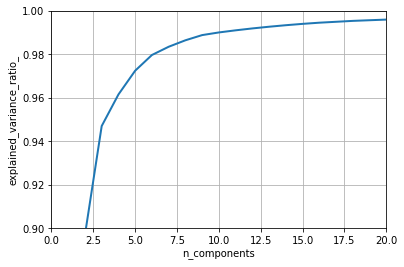

In [120]:
cum_evr = np.cumsum(pca.explained_variance_ratio_)
xs = np.arange(cum_evr.size) + 1
plt.plot(xs, cum_evr, linewidth=2)
plt.grid()
plt.xlabel('n_components')
plt.ylabel('explained_variance_ratio_')
plt.xlim([0, 20])
plt.ylim([0.9, 1])

In [121]:
pca = PCA(n_components=15)

principalComponents = pca.fit_transform(df_train_MCC_PCA.fillna(0).drop(['cl_id'], axis=1))
df_train_MCC_PCA = pd.DataFrame(data = principalComponents , columns = ['p_c_1', 'p_c_2','p_c_3', 'p_c_4','p_c_5', 'p_c_6','p_c_7', 'p_c_8','p_c_9', 'p_c_10','p_c_11', 'p_c_12','p_c_13','p_c_14','p_c_15'])
df_train_MCC_PCA['cl_id'] = df_train['cl_id']

principalComponents = pca.fit_transform(df_test_MCC_PCA.fillna(0).drop(['cl_id'], axis=1))
df_test_MCC_PCA = pd.DataFrame(data = principalComponents , columns = ['p_c_1', 'p_c_2','p_c_3', 'p_c_4','p_c_5', 'p_c_6','p_c_7', 'p_c_8','p_c_9', 'p_c_10','p_c_11', 'p_c_12','p_c_13','p_c_14','p_c_15'])
df_test_MCC_PCA['cl_id'] = df_test['cl_id']

In [122]:
df_train = pd.merge(df_train, df_train_MCC_PCA, how='left', on='cl_id') # For using main components
df_test = pd.merge(df_test, df_test_MCC_PCA, how='left', on='cl_id')

In [124]:
df_train = df_train.fillna(0)
df_test = df_test.fillna(0)

### LogisticRegression

In [127]:
log = LogisticRegression(max_iter=10000, n_jobs=-1)

In [128]:
X_train = df_train.drop(['target_flag'],axis=1)
y_train = df_train['target_flag']
#X = X.to_numpy()

#### Попробуй запусти на 2.5 часа

kf = KFold(len(y),n_splits=10,shuffle=False)
y_pred = y.copy()

for train_index, test_index in tqdm(kf.split(X)):
    X_train, X_test = X[train_index], X[test_index]
    y_train = y[train_index]
        
    log.fit(X_train,y_train)
    
    solver = ['liblinear']
    penalty = ['l1', 'l2']
    C = np.logspace(0, 4, 10)
    hyperparameters = dict(C=C, penalty=penalty,solver=solver)
        
    clf = GridSearchCV(log, hyperparameters, cv=10, verbose=0)
        
    best_model = clf.fit(X_train, y_train)

    y_pred[test_index] = best_model.predict(X_test)

penalty = ['l2']
C = np.logspace(0, 4, 10)
hyperparameters = dict(C=C, penalty=penalty)
        
clf = GridSearchCV(log, hyperparameters, cv=10, verbose=0)
        
best_model = clf.fit(X_train, y_train)

y_pred[test_index] = best_model.predict(X_test)

print(accuracy_score(y,y_pred))
print(f1_score(y,y_pred,average='weighted'))
print(precision_score(y,y_pred,average='weighted'))
print(recall_score(y,y_pred,average='weighted'))
print(r2_score(y,y_pred))

### Lasso LogisticRegression

In [129]:
X_train = df_train.drop(['target_flag'],axis=1)
y_train = df_train['target_flag']
X_test = df_test.drop(['target_flag'],axis=1)
y = df_test['target_flag']

##### Cross Validation

penalty = ['l2','elasticnet']
C = np.logspace(0, 4, 10)
hyperparameters = dict(C=C, penalty=penalty)
log = LogisticRegression(max_iter=10000)

clf = GridSearchCV(log, hyperparameters, cv=10, verbose=0)
        
best_model = clf.fit(X_train, y_train)

y_pred[test_index] = best_model.predict(X_test)

In [131]:
log = LogisticRegression( penalty='l1', solver='liblinear',max_iter=10000, n_jobs=4)
log.fit(X_train,y_train)

D:\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:1353: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn("'n_jobs' > 1 does not have any effect when"
D:\Anaconda\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


LogisticRegression(max_iter=10000, n_jobs=-1, penalty='l1', solver='liblinear')

In [132]:
y_pred_Lasso = log.predict(X_test)

In [133]:
accuracy_score(df_test[['target_flag']], y_pred_Lasso)

0.7655

In [134]:
r2_score(df_test[['target_flag']], y_pred_Lasso)

0.05501086032294844

In [135]:
average_precision_score = average_precision_score(df_test[['target_flag']], y_pred_Lasso)
average_precision_score

0.7385438558480483

In [136]:
score(y,y_pred_Lasso)

accuracy_score = 0.7655
precision_score = 0.7679885354141657
recall_score = 0.7655
f1_score = 0.7659112958299864
r2_score = 0.05501086032294844


### SVC

In [137]:
from sklearn.svm import SVC
from sklearn import svm

In [138]:
clf = svm.SVC()

In [139]:
clf.fit(df_train.drop(['target_flag'], axis=1), df_train['target_flag'])

SVC()

In [140]:
y_pred_CVM = clf.predict(df_test.drop(['target_flag'], axis=1))

In [141]:
score(y,y_pred_CVM)

accuracy_score = 0.653
precision_score = 0.6792346374911662
recall_score = 0.653
f1_score = 0.64899146639524
r2_score = -0.39834213845602084


In [142]:
rbf_kernel_svm_clf = SVC(kernel="rbf", gamma=5, C=0.001)
rbf_kernel_svm_clf.fit(X_train, y_train)

SVC(C=0.001, gamma=5)

In [143]:
y_pred_rbf = clf.predict(X_test)

In [144]:
score(y,y_pred_rbf)

accuracy_score = 0.653
precision_score = 0.6792346374911662
recall_score = 0.653
f1_score = 0.64899146639524
r2_score = -0.39834213845602084


## Polynomial kernel

In [146]:
from sklearn.svm import SVC

In [147]:
poly_kernel_svm = SVC(kernel="poly")

In [148]:
poly_kernel_svm.fit(df_train.drop(['target_flag'], axis=1), df_train['target_flag'])

SVC(kernel='poly')

In [149]:
y_pred_poly_kernel = poly_kernel_svm.predict(df_test.drop(['target_flag'], axis=1))

In [150]:
score(y,y_pred_poly_kernel)

accuracy_score = 0.55275
precision_score = 0.6944867083191916
recall_score = 0.55275
f1_score = 0.40659609799928564
r2_score = -0.8023300329235024


#### LGBModel

In [118]:
from sklearn.model_selection import RepeatedStratifiedKFold
import lightgbm as lgb
skf = RepeatedStratifiedKFold(n_splits=8, n_repeats=5, random_state=201805)

In [119]:
lgb_data_train = lgb.Dataset(df_train.drop(['target_flag'],axis=1), 
                             df_train['target_flag'], 
                             free_raw_data=False
                            )

params = {
    'objective':'binary', 
    'metric': 'auc',
    'learning_rate': 0.01, 
    'random_state':4242442,
    'subsample':0.33,
    'class_weight':'balanced',
    'colsample_bytree':0.33,
    'reg_lambda':4
}

h = lgb.cv(params, 
           lgb_data_train, 
           num_boost_round=10000,
           early_stopping_rounds=50, 
           verbose_eval=10, 
           folds=skf.split(df_train, df_train['target_flag'])
          )

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 1940, number of negative: 1560
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13141
[LightGBM] [Info] Number of data points in the train set: 3500, number of used features: 78
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 1940, number of negative: 1560
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012498 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 1940, number of negative: 1560
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13141
[LightGBM] [Info] Number of data points in the train set: 3500, number of used features: 78
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 1940, number of negative: 1560
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13141
[LightGBM] [Info] Number of data points in the train set: 3500, number of used features: 78
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [W

[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 1939, number of negative: 1561
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13141
[LightGBM] [Info] Number of data points in the train set: 3500, number of used features: 78
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 1940, number of negative: 1560
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 13141
[LightGBM] [Info] Number of data points in the train set: 3500, number of used features: 78
[LightGBM] [W

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554286 -> initscore=0.218002
[LightGBM] [Info] Start training from score 0.218002
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554286 -> initscore=0.218002
[LightGBM] [Info] Start training from score 0.218002
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554286 -> initscore=0.218002
[LightGBM] [Info] Start training from score 0.218002
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554000 -> initscore=0.216846
[LightGBM] [Info] Start training from score 0.216846
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554286 -> initscore=0.218002
[LightGBM] [Info] Start training from score 0.218002
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554286 -> initscore=0.218002
[LightGBM] [Info] Start training from score 0.218002
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554286 -> initscore=0.218002
[LightGBM] [Info] Start training from score 0.218002
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.554286 -> initscore=0.2180

## Домашняя работа 2

1. **Обязательная часть**: на том же наборе данных провести feature engineering:
    - создать Weights of Evidence (WOE) фичи на тех переменных, где категорий большое количество
    - cделать one hot encoding там, где необходимо
    - по желанию посчитать каунты (counts)
    
2. **Обязательная часть**: обучить linear SVM и SVM с нелинейным ядром - сравнить время обучения и результат метрики оценки качества (ROC AUC) двух алгоритмов между собой и сравнить с линейной моделью (лог.рег)